In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from process_data import process_data
from policy import LinUCB, FixedDose, ClinicalDose, LassoUCB, RobustLinExp3, LinTS, PharmacogeneticDose
from bandit import ContextualBandit

def run(bandit, policy, T=1000, num_trials=3, seed=2023):
    
    cum_regrets = []
    correctness = []
    np.random.seed(seed)
    
    for i, trial_seed in enumerate(np.random.randint(1, 100, num_trials)):
        
        bandit.reset(seed=trial_seed)
        policy.reset()
        
        for t in tqdm(range(T)):
            
            fea, lab = bandit.present()
            arm = policy.predict(fea, lab, t)
            reward = bandit.pull(arm)
            if policy.__class__.__name__ in ['RobustLinExp3']:
                policy.update(fea, lab, reward) 
            else:                           
                policy.update(fea, arm, reward)
        
        correctness.append(bandit.correctness[-1])
    
    return correctness

In [4]:
path = 'data/warfarin.csv'
features, labels = process_data(path)

cors = []
nus = [0.003, 0.01, 0.03, 0.1]
for nu in nus:
    lints_cb = ContextualBandit(features=features, labels=labels)
    lints = LinTS(num_features=lints_cb.num_features, num_labels=lints_cb.k, nu=nu)
    cor = run(lints_cb, lints, T=features.shape[0], num_trials=1, seed=2023)
    cor = sum(cor)
    cors.append(cor)

  2%|▏         | 115/5528 [00:03<02:20, 38.59it/s]/home/liang/CS234_final_project/cs234_project/policy.py:242: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  mu_t = np.random.multivariate_normal(self.mu_hat[arm], self.nu ** 2 * B_inv)
100%|██████████| 5528/5528 [03:04<00:00, 29.97it/s]


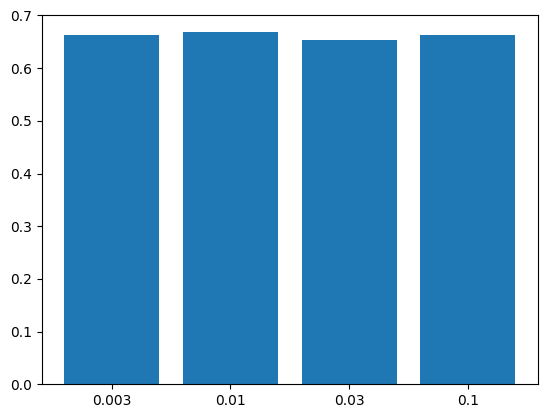

In [8]:
nus = [str(i) for i in nus]
plt.bar(nus, cors)
plt.show()    